In [52]:
import pyshtools

coeffs = pyshtools.SHGravCoeffs.from_file("ITSG_ITSG-Grace2014_daily_2006_ITSG-Grace2014_2006-11-15.gfc",format='icgem')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spherical harmonic degree', ylabel='Power, m$^2$'>)

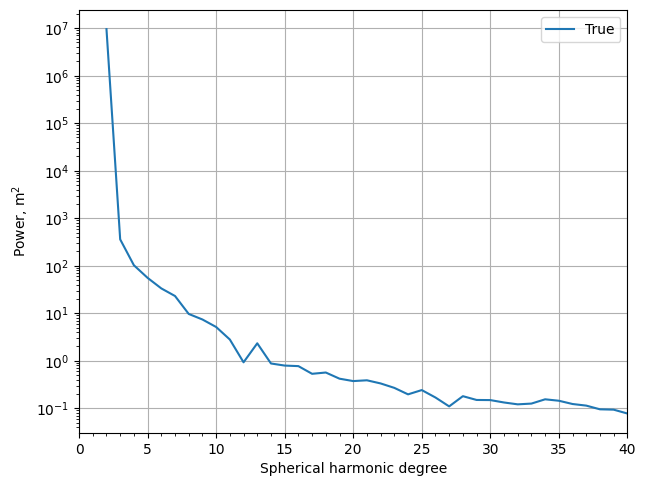

In [55]:
coeffs.plot_spectrum(unit='per_l',xscale='lin',yscale='log',legend=True)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spherical harmonic degree', ylabel='Power, m$^2$'>)

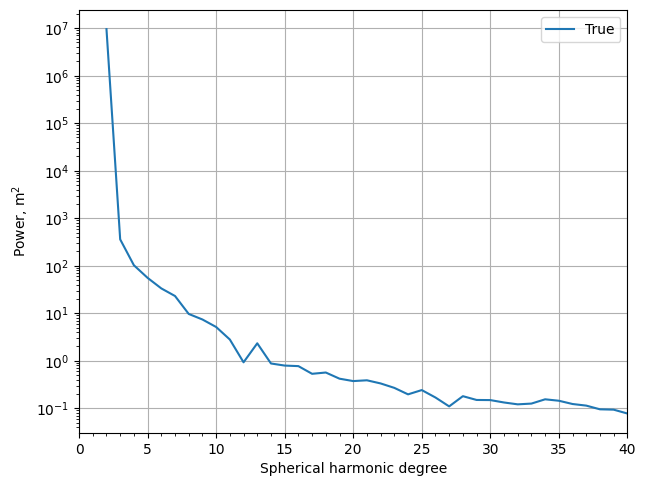

In [75]:
coeffs = pyshtools.SHGravCoeffs.from_file(
    "ITSG_ITSG-Grace2014_daily_2006_ITSG-Grace2014_2006-11-15.gfc", format="icgem"
)

coeffs.plot_spectrum(unit="per_l", xscale="lin", yscale="log", legend=True)

In [77]:
modified_coeffs = coeffs.coeffs.copy()


In [78]:
modified_coeffs

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.84169230e-04, -3.16725463e-10,  2.43934849e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-2.42891196e-09,  5.09226001e-09,  7.50387002e-09, ...,
          2.80790556e-09,  0.00000000e+00,  0.00000000e+00],
        [ 1.29296498e-09, -4.43005616e-09,  3.06405402e-09, ...,
         -9.43950324e-10, -1.20297744e-10,  0.00000000e+00],
        [-6.21878232e-09,  3.80699560e-09, -1.12115362e-09, ...,
          3.74792100e-10,  6.46380973e-09, -1.77569476e-09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

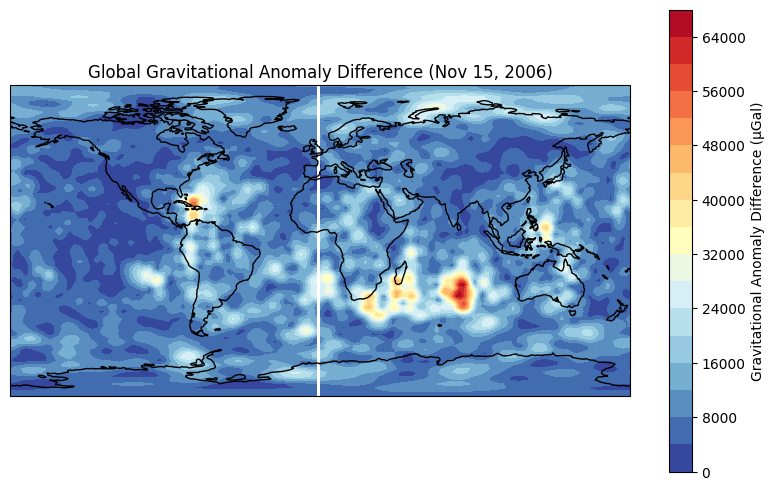

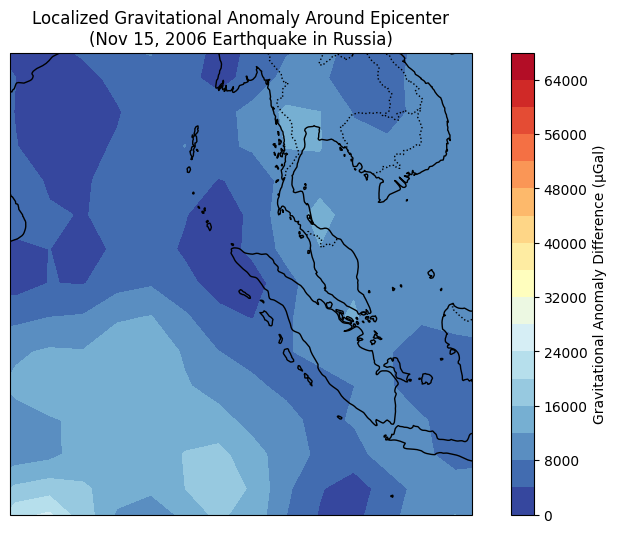

In [76]:
import pyshtools as pysh
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Function to load spherical harmonic coefficients from a GRACE GFC file.
def load_sh_grav_coeffs(gfc_file):
    """Load spherical harmonic coefficients using pyshtools."""
    coeffs = pysh.SHGravCoeffs.from_file(gfc_file, format='icgem')
    return coeffs

# Function to compute gravity anomaly excluding the first 5 degrees.
def compute_gravity_anomaly_excluding_first5(coeffs):
    """
    Compute gravity anomaly while excluding the first 5 degrees.
    The coefficients for l = 0 to 4 (and here l=0 to 9 in the coefficient array,
    since the array is indexed such that [:10] corresponds to l=0..4)
    are set to zero.
    """
    # Use the provided planetary constants:
    gm = 3.9860044150e+14   # [m^3/s^2]
    r0 = 6.3781363000e+06    # [m]

    # Copy coefficients and zero out degrees 0-4.
    modified_coeffs = coeffs.coeffs.copy()
    modified_coeffs[:, 0:20, :] = 0  # Zero out l = 0 to 4 for both cosine and sine parts

    # Compute gravity components using pyshtools.
    rad, theta, phi, total, pot = pysh.gravmag.MakeGravGridDH(
        modified_coeffs, gm, r0, lmax=coeffs.lmax, normal_gravity=1
    )

    combined_total = np.sqrt(rad**2 + theta**2 + phi**2)

    g_ref = gm / (r0**2)

    total = total - g_ref

    return total

if __name__ == "__main__":
    # Paths to the GRACE GFC files for the two consecutive days.
    gfc_file1 = "CSR_CSR-Release-06_60x60_unfiltered_GSM-2_2006274-2006304_GRAC_UTCSR_BA01_0600.gfc"
    gfc_file2 = "ITSG_ITSG-Grace2014_daily_2004_ITSG-Grace2014_2004-12-26.gfc"

    # Load the spherical harmonic coefficients.
    coeffs1 = load_sh_grav_coeffs(gfc_file1)
    coeffs2 = load_sh_grav_coeffs(gfc_file2)

    # Compute the gravity anomalies for the two dates.
    anomaly1 = compute_gravity_anomaly_excluding_first5(coeffs1)
    anomaly2 = compute_gravity_anomaly_excluding_first5(coeffs2)

    # Compute the difference (post-event minus pre-event).
    anomaly_difference = anomaly2

    # Convert the results to microGals.

    anomaly_difference *= 1e8

    # Set up the grid.
    # Note: MakeGravGridDH returns a grid with dimensions (nlat, 2*nlat) 
    # because it uses a Driscoll & Healy grid.
    grid_size = anomaly2.shape[0]
    latitudes = np.linspace(-90, 90, grid_size)
    longitudes = np.linspace(0, 360, 2 * grid_size, endpoint=False)
    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

    # ---------------- Global Plot ----------------
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE)
    pcm = ax.contourf(
        lon_grid, lat_grid, anomaly_difference,
        transform=ccrs.PlateCarree(), cmap="RdYlBu_r", levels=20
    )
    plt.colorbar(pcm, ax=ax, label="Gravitational Anomaly Difference (µGal)")
    plt.title("Global Gravitational Anomaly Difference (Nov 15, 2006)")
    plt.show()

    # ---------------- Spatial Localization ----------------
    # Define the earthquake epicenter and a region around it.
    epicenter_lat = 3.316   # example: 55.5° N
    epicenter_lon = 95.854  # example: 161.0° E

    # Define the bounds of the zoomed region (e.g., ±10° around the epicenter)
    lat_min = epicenter_lat - 15
    lat_max = epicenter_lat + 15
    lon_min = epicenter_lon - 15
    lon_max = epicenter_lon + 15

    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    # Set the plot extent to the region around the epicenter.
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Plot the localized anomaly difference.
    pcm = ax.contourf(
        lon_grid, lat_grid, anomaly_difference,
        transform=ccrs.PlateCarree(), cmap="RdYlBu_r", levels=20
    )
    plt.colorbar(pcm, ax=ax, label="Gravitational Anomaly Difference (µGal)")
    plt.title("Localized Gravitational Anomaly Around Epicenter\n(Nov 15, 2006 Earthquake in Russia)")
    plt.show()


In [50]:
coeffs1.coeffs

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.84169279e-04, -2.53469358e-10,  2.43936008e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-3.47569599e-09, -1.98087023e-09,  2.14612864e-09, ...,
         -1.33660468e-10,  0.00000000e+00,  0.00000000e+00],
        [ 3.54473341e-09, -3.33879237e-09,  4.70830251e-09, ...,
          1.74708689e-09,  2.09853327e-09,  0.00000000e+00],
        [-8.71592302e-10,  1.87701696e-09,  3.48763657e-09, ...,
         -1.82269085e-09, -2.45390288e-09,  3.78121817e-09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e